In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from scipy.spatial import distance

import matplotlib.pyplot as plt

import hmpldat.file.participant

X_AXIS = [1, 0, 0]
Y_AXIS = [0, 1, 0]
Z_AXIS = [0, 0, -1]
ORIGIN = [0, 0, 0]

# define by 3 points to keep direction consistent
XZ_PLANE = np.array([ORIGIN, Z_AXIS, X_AXIS])
# YZ_PLANE = 
# XY_PLANE = 

In [2]:
p_a = hmpldat.file.participant.participant('VMIB', '047')

p_a.rawetg_path = Path(f'~/Desktop/selected_data/VMIB/Data/ETG/Metrics Export/VMIB_{p_a.name}_RawETG.txt')
p_a.detections_path = Path(f'~/Desktop/selected_data/VMIB/Data/detections/vmib_{p_a.name}-1-unpack.txt')

# p.create_file_listing(Path('selected_data_file_listing.xlsx'), Path('/home/ian/Desktop/selected_data/VMIB/Data'))
p_a.load_file_listing(
    Path('/home/ian/Projects/hmpldat/selected_data_file_listing.xlsx')
)

p_a.load_rawetg_and_objects()

p_a.create_tasks()
output_data_dir = Path(f'/home/ian/Projects/hmpldat/temporal_alignment_data/{p_a.experiment}/{p_a.name}')

# don't overwrite data by default
# if output_data_dir.exists():
#     i = input("directory already exists. continue? [Y/n] ")
#     if i.lower() == 'n':
#         exit()
# else:
#     output_data_dir.mkdir(parents=True)

    


ap, 1
avoid, 1
bm, 1
ducks, 1
There was an error on ('ducks', 1) : "None of ['time'] are in the columns"
ducks, 2
ducks, 3
There was an error on ('dynamic', 1) : 'dynamic'
fix, 1
hp, 1
int, 1
pp, 1
qs_closed, 1
qs_cross, 1
qs_open, 1
There was an error on ('static', 1) : 'static'
ts, 1
There was an error on ('ts', 1) : index 0 is out of bounds for axis 0 with size 0
vt, 1
There was an error on ('vt', 1) : 'crossvisible.bool'


In [3]:
# for f in search.files(DATA_PATH, []):  # a_task or all_tasks_from_one_session

p_b = hmpldat.file.participant.participant('VMIB', '005')

p_b.rawetg_path = Path(f'~/Desktop/selected_data/VMIB/Data/ETG/Metrics Export/VMIB_{p_b.name}_RawETG.txt')
p_b.detections_path = Path(f'~/Desktop/selected_data/VMIB/Data/detections/vmib_{p_b.name}-1-unpack.txt')

# p.create_file_listing(Path('selected_data_file_listing.xlsx'), Path('/home/ian/Desktop/selected_data/VMIB/Data'))
p_b.load_file_listing(
    Path('/home/ian/Projects/hmpldat/selected_data_file_listing.xlsx')
)

p_b.load_rawetg_and_objects()

p_b.create_tasks()
output_data_dir = Path(f'/home/ian/Projects/hmpldat/temporal_alignment_data/{p_b.experiment}/{p_b.name}')

# don't overwrite data by default
# if output_data_dir.exists():
#     i = input("directory already exists. continue? [Y/n] ")
#     if i.lower() == 'n':
#         exit()
# else:
#     output_data_dir.mkdir(parents=True)


ap, 1
avoid, 1
bm, 1
ducks, 1
There was an error on ('ducks', 1) : 'crossvisible.bool'
There was an error on ('dynamic', 1) : 'dynamic'
fix, 1
hp, 1
int, 1
pp, 1
qs_closed, 1
qs_cross, 1
qs_open, 1
There was an error on ('static', 1) : 'static'
ts, 1
There was an error on ('ts', 1) : index 0 is out of bounds for axis 0 with size 0
vt, 1
There was an error on ('vt', 1) : 'crossvisible.bool'


In [4]:
def angle_diff(angles):
    """ 
    calculate difference between angles at each time step
    
    handle when angle switches between pi and negative pi
    """

    difference = np.abs(angles.diff())

    difference.loc[difference > 6] = np.pi * 2 - difference.loc[difference > 6] 

    # df = pd.concat([difference, angles], axis=1)
    # df.to_csv('hopes_and_dreams.csv')

    return difference

In [5]:
import itertools
def calc_head_rotations(task):
    """head rotation around each axis

    pitch, roll, and yaw

    """
    # print(task.name)

    # TODO: handle antler glasses markers
    ETG_GLASSES_POINTS = ['lhead', 'rhead', 'fhead']
    cartesan = ['x', 'y', 'z']

    marker_names = [".".join([a,b]) for a, b in itertools.product(ETG_GLASSES_POINTS, cartesan)]

    glasses_markers = task[marker_names]
    glasses_markers.columns = pd.MultiIndex.from_tuples(list(tuple(l) for l in glasses_markers.columns.str.split(".")))
    # print(glasses_markers)

    centeroids = glasses_markers.groupby(axis=1, level=[1]).sum() / 3
    # print(centeroids)

    ### ROTATION AROUND DIFFERENT AXES ###
    # project points onto xz plane
    angle_x = np.arctan2(centeroids['y'], centeroids['x'])
    angle_y = np.arctan2(centeroids['z'], centeroids['x'])
    angle_z = np.arctan2(centeroids['y'], centeroids['z'])

    angles = pd.DataFrame({
        'x': angle_x,
        'y': angle_y,
        'z': angle_z,
    })

    df = pd.DataFrame(angles)

    df = df.apply(angle_diff)

    return df

In [6]:
def hip_rotation(task):
    """ """

    hip_markers = ['lasis', 'rpsis', 'rasis', 'lasis']

    rotation = {}

    for m in hip_markers:
        marker = task[[f'{m}.x', f'{m}.y', f'{m}.z']]
        marker.columns = ['x', 'y', 'z']

        angle_y = np.arctan2(marker['z'], marker['x'])

        rotation[m] = angle_y

    df = pd.DataFrame(rotation)
    # print(df.dropna())

    df = df.apply(angle_diff)
    # print(df.dropna())

    return df

In [7]:
def as_unit_vector(v):
    """
    return unit vector
    """

    return v / np.linalg.norm(v)



In [8]:
def angle_between_vectors(a1, a2, b1, b2):
    """ find angle between these vectors defined by these points 
    
    each vector defined by two points (a1 -> a2) and (b1 -> b2)
    """

    a_u = as_unit_vector(a2 - a1)
    b_u = as_unit_vector(b2 - b1)

    df = np.arccos(np.clip(np.dot(a_u, b_u), -1.0, 1.0))
    
    # dataframe of angle (radians)
    return df

In [9]:
def total_marker_distance(task):
    """ return total distance traveled for each marker """

    markers = [
        'fhead', 'rhead', 'thead', 'lhead', 'c7', 'bbac', 'offset_nav', 'xyph', 'strn', 'lsho', 'rsho', 'lasis', 'lpsis', 'rasis', 'rpsis',
        'sacrum', 'rlm', 'rhee', 'rtoe', 'rmt5', 'lhee', 'ltoe', 'lmt5', 'v_rshoulder', 'v_lshoulder', 'v_neck', 'v_lshoulder_dyn', 'v_rshoulder_dyn',
        'v_mid_asis_dyn', 'v_head', 'v_mid_psis', 'v_rfoot', 'v_lfoot', 'v_rankle_dyn', 'v_neck2', 'v_pelvis', 'v_sacrum'
    ]

    dist_traveled = {}

    for m in markers:
        marker = task.merged[[f'{m}.x', f'{m}.y', f'{m}.z']]

        marker_shft = marker.shift()

        dist_traveled_each_step = np.linalg.norm(marker - marker_shft, axis=1)

        dist_traveled[m] = dist_traveled_each_step

    dist_traveled = pd.DataFrame(dist_traveled)

    total_distance_traveled = np.sum(dist_traveled, axis=0)
    
    return total_distance_traveled


In [10]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

pd.set_option('mode.chained_assignment', None)
# TODO not used for this paper , fix at a later time
def parse_sacade_data(sacade):
    try:
        first = True
        notIn = True
        count = 0
        errorCount = 0
        countP = 0
        errorCountP = 0
        for data in sacade:
            if (np.isnan(data[0][4]) or np.isnan(data[1][4])):
                continue
            if(first):
                first=False
                firstAbs = data[1][4]
                firstPrc = data[1][4] / data[0][4]
            if(notIn and (data[1][4] > data[0][4])):
                errorCount += 1
            if(notIn and (data[0][5])):
                sacadeCount = count
                notIn = False
            count += 1
            if (notIn and (data[1][5])):
                sacadeCount = count
                notIn = False
            if (not notIn):
                countP += 1
                if (data[1][4] > data[0][4]):
                    errorCountP += 1
        return {
            "First sacade error" : firstAbs,
            "first sacade percent error" : firstPrc,
            "Sacade count to reach" : sacadeCount,
            "Percent of error sacades" : errorCount/sacadeCount,
            "pursuit count" : countP,
            "pursuit error count" : errorCountP
        }
    except Exception as e:
        return str(e)

def target_seeking_sacade_measure(task):
    if not hasattr(task, 'merged'):
        #TODO throw error or try to create merged file in the future
        print("does not have merged file")
        return None
    cleaned = task.merged.copy()
    # required_columns = merged.loc[:, merged.columns.str.contains(
    #     '.head|target(\.|v)|cross(\.|v)|user(\.|v)|safezone|grid')].columns
    # cleaned = merged.dropna(subset=required_columns, thresh=29)
    # cleaned = cleaned[cleaned['trial_number'].notna()]
    
    cleaned["xDif"] = cleaned["Point of Regard Binocular X [px]"].diff()
    cleaned["yDif"] = cleaned["Point of Regard Binocular Y [px]"].diff()
    cleaned["gazeDiff"] = np.sqrt(cleaned["xDif"] ** 2 + cleaned["yDif"] ** 2)
    cleaned["tcenter.x"] = (cleaned["target.right"] + cleaned["target.left"]) / 2
    cleaned["tcenter.y"] = (cleaned["target.bottom"] + cleaned["target.top"]) / 2
    cleaned["tcenter.dist"] = np.sqrt(
        (cleaned["tcenter.x"] - cleaned["Point of Regard Binocular X [px]"]) ** 2 +
        (cleaned["tcenter.y"] - cleaned["Point of Regard Binocular Y [px]"]) ** 2)
    insideTarget = []
    for i, dat in cleaned.iterrows():
        insideTarget.append(dat["tcenter.dist"] < 55)
            # (dat["Point of Regard Binocular X [px]"] > dat["target.left"]) and
            # (dat["Point of Regard Binocular X [px]"] < dat["target.right"]) and
            # (dat["Point of Regard Binocular Y [px]"] > dat["target.top"]) and
            # (dat["Point of Regard Binocular Y [px]"] < dat["target.bottom"]))
    cleaned['insideTarget'] = insideTarget

    #Category Binocular
    trials = cleaned["trial_number"].unique()
    trialData = []
    for trial in trials:
        if np.isnan(trial):
            continue
        trial_data = cleaned[(cleaned["trial_number"] == trial) & (cleaned["targetvisible.bool"] == True)]
        offset = trial_data.index[0] + 0.6
        # trial_data["plot_time"] = trial_data["corrected_frame_time"] - offset

        # plt.figure(figsize=(18, 9))
        # sns.scatterplot(data=trial_data, x='plot_time', y='gazeDiff',
        #                 hue='insideTarget').get_figure().show()
        # print(trial_data["target.right"])
        try:
            target_time = trial_data[trial_data["insideTarget"] == True].index[0]
            target_time = target_time - trial_data.index[0]
        except:
            target_time = None

        # TODO not used for this paper but fix the code at a later time

        # sacade = False
        # sacadeData = []
        # for i,dat in trial_data.iterrows():
        #     if(not sacade and dat["Category Binocular"] != "Saccade"):
        #         continue
        #     if (sacade and dat["Category Binocular"] == "Saccade"):
        #         continue
        #     if(not sacade and dat["Category Binocular"] == "Saccade"):
        #         ssx = dat["Point of Regard Binocular X [px]"]
        #         ssy = dat["Point of Regard Binocular Y [px]"]
        #         sstx = dat["tcenter.x"]
        #         ssty = dat["tcenter.y"]
        #         ssdist = dat["tcenter.dist"]
        #         ssin = dat['insideTarget']
        #         sstime = dat['corrected_frame_time']
        #         sacade = True
        #     if (sacade and dat["Category Binocular"] != "Saccade"):
        #         esx = dat["Point of Regard Binocular X [px]"]
        #         esy = dat["Point of Regard Binocular Y [px]"]
        #         estx = dat["tcenter.x"]
        #         esty = dat["tcenter.y"]
        #         esdist = dat["tcenter.dist"]
        #         esin = dat['insideTarget']
        #         estime = dat['corrected_frame_time']
        #         sacade = False
        #         sacadeData.append(((ssx,ssy,sstx,ssty,ssdist,ssin,sstime),(esx,esy,estx,esty,esdist,esin,estime)))

        trialData.append(target_time)

    return trialData


In [11]:
def gaze_distance(trial):
    """ point to point pixel distance """

    # print(trial
    gaze_pixel = trial[['Point of Regard Binocular X [px]', 'Point of Regard Binocular Y [px]']]
    gaze_pixel.columns = ['u','v']

    shift_gaze_pixel = gaze_pixel.shift()
    # print(shift_gaze_pixel)

    gaze_distance = np.sqrt((gaze_pixel.u - shift_gaze_pixel.u)**2 + (gaze_pixel.v - shift_gaze_pixel.v)**2)
    
    return gaze_distance
  

def dist_vel_acc(trial):
    
    gaze_dist = gaze_distance(trial)
    # gaze_acceleration = gaze_velocity

    # return pd.DataFrame([gaze_velocity, gaze_acceleration], columns=['gaze_dist', 'acceration'])  
    return gaze_dist 


def gaze_distance2target(trial):
    """ target center """
    gaze_pixel = trial[['Point of Regard Binocular X [px]', 'Point of Regard Binocular Y [px]']]
    gaze_pixel.columns = ['u','v']

    target_center = trial[['target.u', 'target.v']]
    target_center.columns = ['u','v']

    dist2target = np.sqrt((gaze_pixel.u - target_center.u)**2 + (gaze_pixel.v - target_center.v)**2)
    return dist2target

def reached_target(trial, thresh=55):
    """ did the participant reach the target threshold in pixels """

    reached_target = (gaze_distance2target(trial) < thresh)
    return reached_target



In [12]:
# difference 
def calc_reaction_time(trial):
    """  """
    target_appears = trial[trial['targetvisible.bool'] == 1].index
    if target_appears.empty:
        return np.NaN
    
    trial = trial.loc[(trial.index > target_appears[0]), :]
    saccade = trial[trial['Category Binocular'] == 'Saccade'].index

    # no saccade labeled by BeGaze
    if saccade.empty:
        return np.NaN

    # evaluate using our own measure of eye movement??

    reaction = saccade[0] - target_appears[0]
    if reaction > 1:
        return np.NaN

    return reaction


# difference 
def time2target(trial):
    """  """
    target_appears = trial[trial['targetvisible.bool'] == 1].index

    if target_appears.empty:
        return np.NaN

    trial = trial.loc[(trial.index > target_appears[0]), :]

    target_found = trial[reached_target(trial)].index
    # print(target_found)

    # target never found (threshold)
    if target_found.empty:
        return np.NaN

    return target_found[0] - target_appears[0]

In [16]:
from pprint import pprint
# gaze stats per trial
gaze_info = {}

for p in [p_a, p_b]:

    pname = f'{p.experiment}_{p.name}'
    gaze_info[pname] = {}

    for task in p.tasks.values():

        # if task.name != "int":
        #     continue
        
        # skip tasks without merged data
        if not hasattr(task, 'merged'):
            print(f'ERROR: {task.name} does not have merged data')
            continue

        # calc trial number
        task.trial_number()

        gaze_info[f'{p.experiment}_{p.name}'][task.name] = {}        

        # writer = pd.ExcelWriter(f"each_trial_{pname}_{task.name}.xlsx")

        for k, g in task.merged.groupby('trial_number'):
            
            trial = str(int(k))

            # g = g[
            #     [
            #         'Point of Regard Binocular X [px]',
            #         'Point of Regard Binocular Y [px]',
            #         'Category Binocular',
            #         'targetvisible.bool',
            #         'target.u',
            #         'target.v'
            #     ]
            # ]

            # check each gaze point (in scene, in range)
            g = g.assign(
                in_range=(g["Point of Regard Binocular X [px]"].between(-218, 1178)
                          & g["Point of Regard Binocular Y [px]"].between(-130, 850)),
                in_scene=(g["Point of Regard Binocular X [px]"].between(0, 960)
                          & g["Point of Regard Binocular Y [px]"].between(0, 720))
            )

            # g.to_excel(writer, sheet_name=f"trial #{trial}")


            gaze_info[f'{p.experiment}_{p.name}'][task.name][trial] = {
                'total': g.shape[0],
                'reaction_time': calc_reaction_time(g),
                'time2target': time2target(g),
                'in_scene': ((g['in_scene'] == True) & (g['in_range'] == True)).sum(),
                'in_range_off_scene': ((g['in_scene'] == False) & (g['in_range'] == True)).sum(),
                'out_of_range': (g['in_range'] == False).sum(),
                'blink': (g['Category Binocular'] == 'Blink').sum(),
                'saccade': (g['Category Binocular'] == 'Saccade').sum(),
            }
        # print(gaze_info[f'{p.experiment}_{p.name}'][task.name])
    
    # try:
    #     writer.close()
    # except Exception as e:
    #     print(e)

    # # deference between ball appearance 
    gaze_info[pname] = pd.concat(
        [pd.DataFrame(t) for t in gaze_info[f'{p.experiment}_{p.name}'].values()], 
        keys=gaze_info[f'{p.experiment}_{p.name}'].keys(), axis=0).T
    
    # gaze = np.degrees(gaze)
    # gaze.describe().to_csv('out.csv', mode='a')
    # print(f'{p.experiment}_{p.name}')
    # print(gaze)
    # gaze[('int', 'reaction_time')].to_csv(f'{p.name}_int_reaction_time.csv')
    # print(gaze['int', 'reaction_time'].describe())
    # print()

df = pd.concat(gaze_info, axis=1)
df.describe().to_csv("trials")
print(df.describe())

ERROR: ducks does not have merged data
ERROR: ducks does not have merged data
ERROR: qs_closed does not have merged data
ERROR: qs_cross does not have merged data
ERROR: qs_open does not have merged data
ERROR: qs_closed does not have merged data
ERROR: qs_cross does not have merged data
ERROR: qs_open does not have merged data
         VMIB_047                                                           \
               ap                                                            
            total reaction_time time2target    in_scene in_range_off_scene   
count   90.000000     69.000000   85.000000   90.000000          90.000000   
mean   465.966667      0.169324    0.323039  433.911111           5.088889   
std     34.655755      0.177212    0.482446   50.318010          13.501265   
min    424.000000      0.008333    0.008333  308.000000           0.000000   
25%    445.250000      0.075000    0.025000  403.250000           0.000000   
50%    455.000000      0.100000    0.150000  4

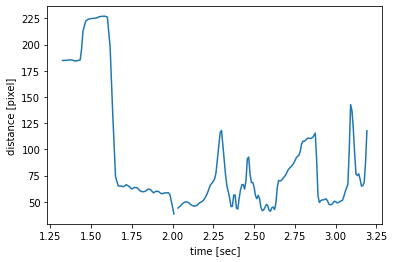

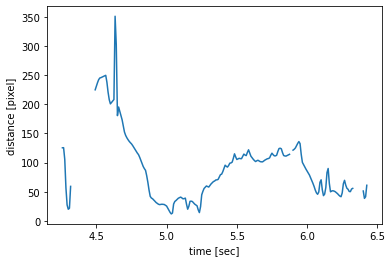

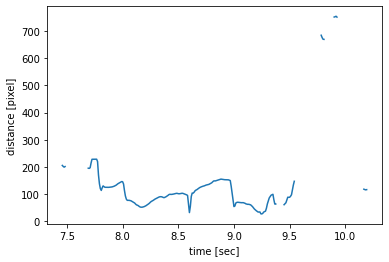

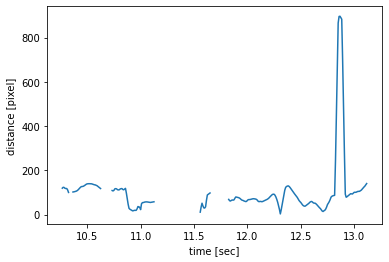

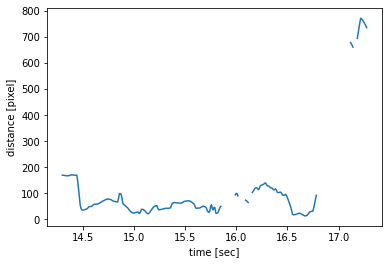

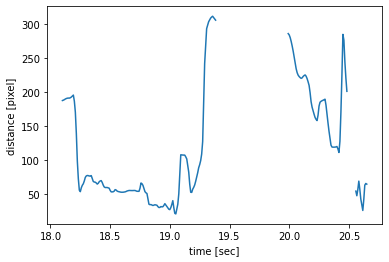

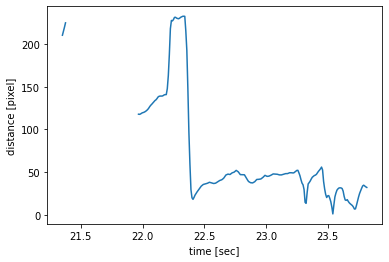

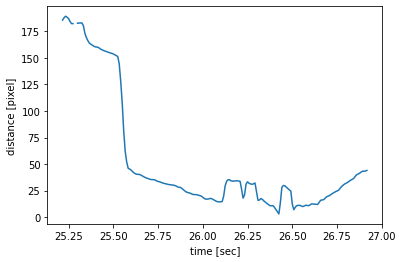

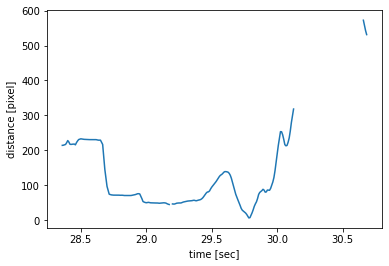

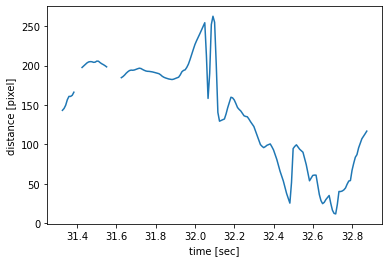

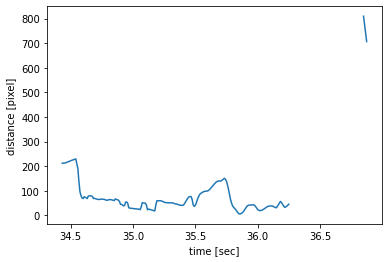

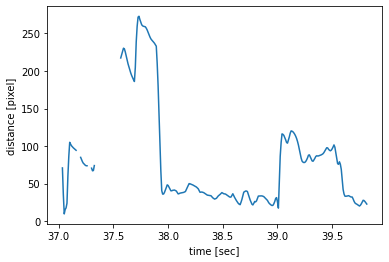

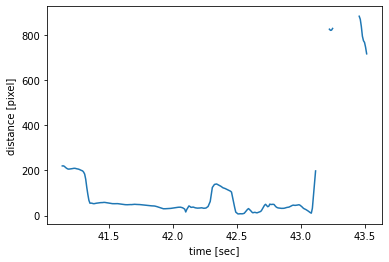

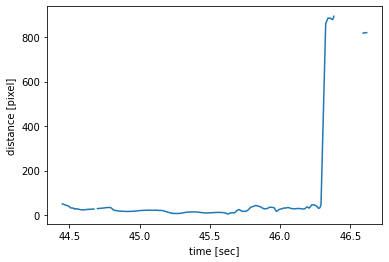

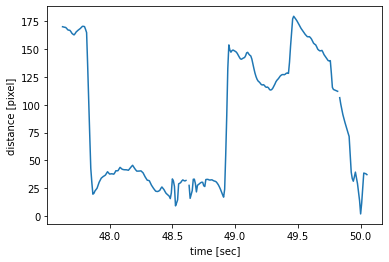

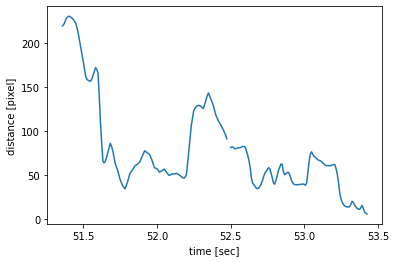

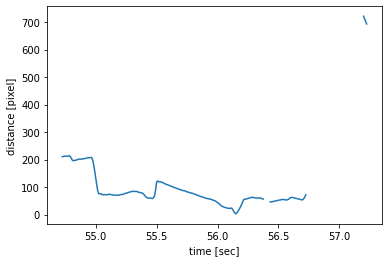

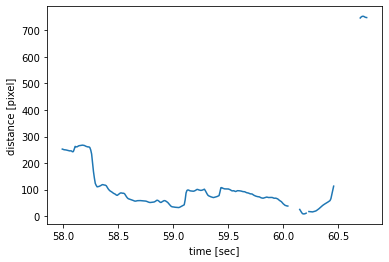

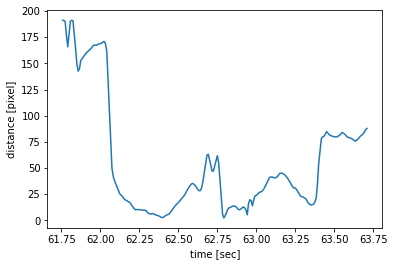

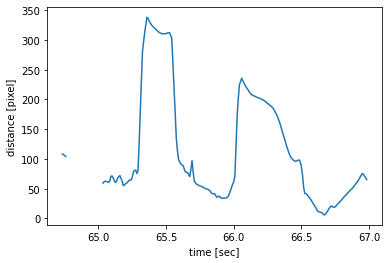

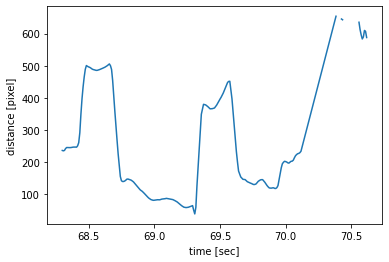

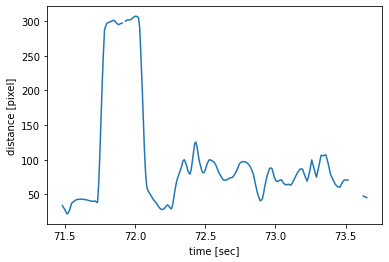

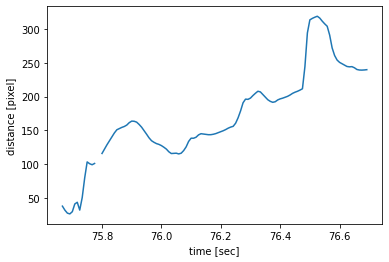

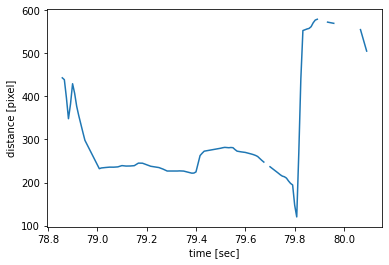

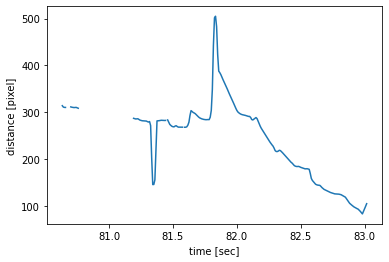

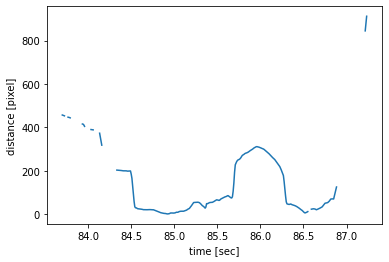

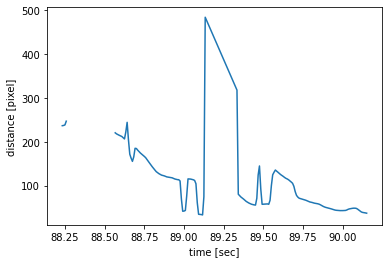

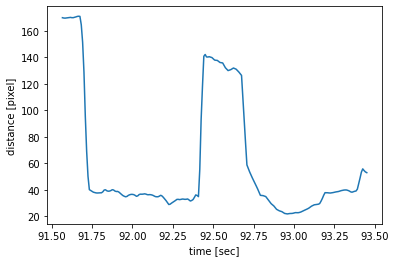

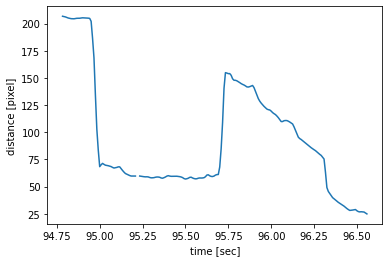

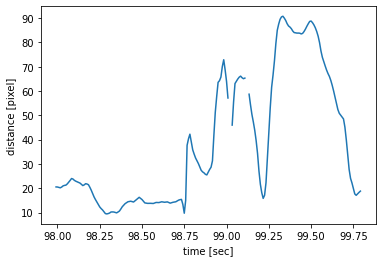

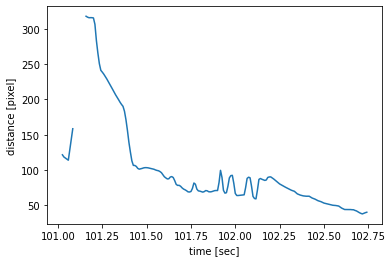

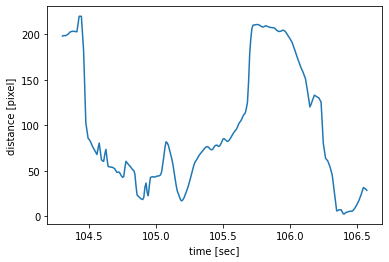

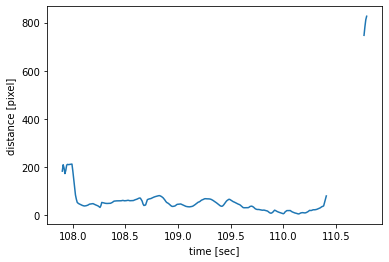

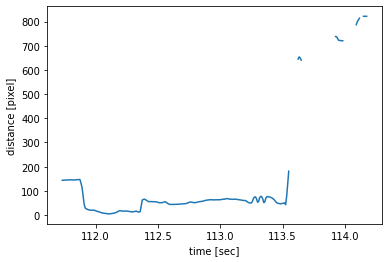

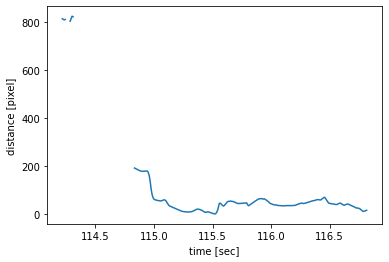

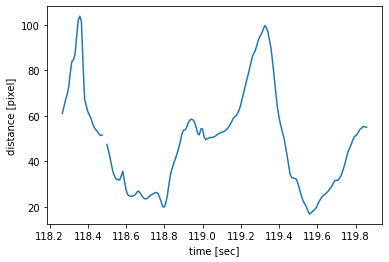

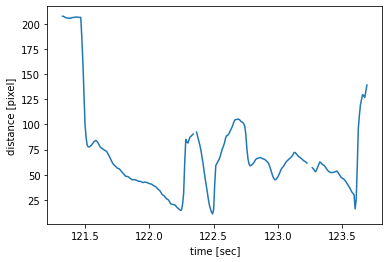

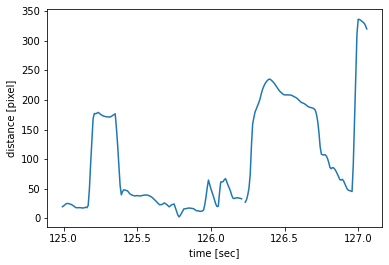

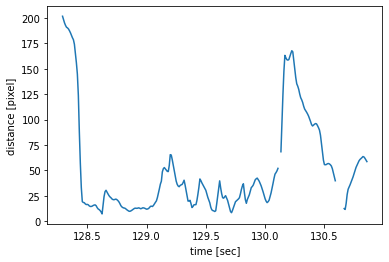

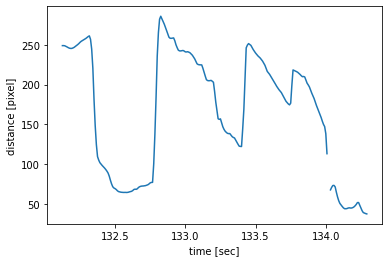

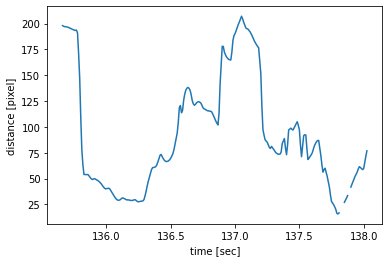

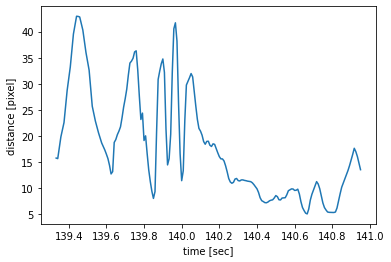

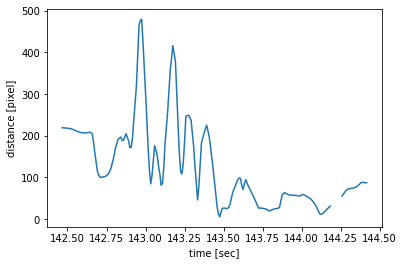

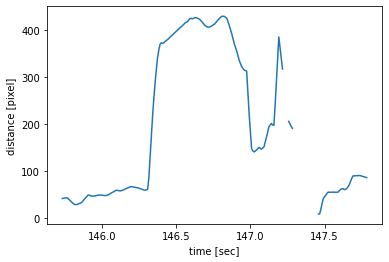

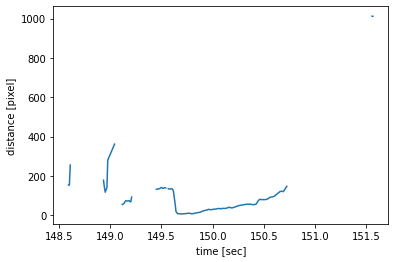

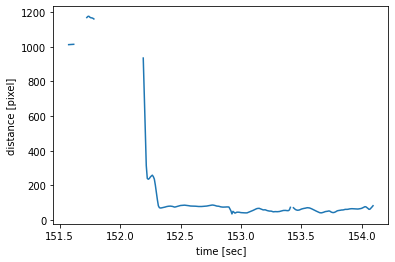

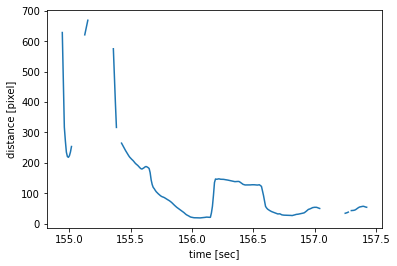

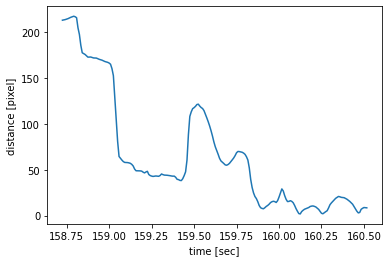

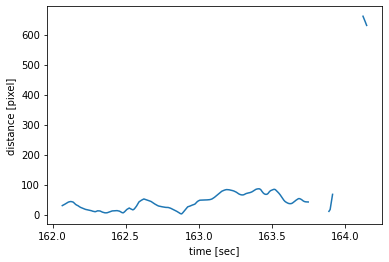

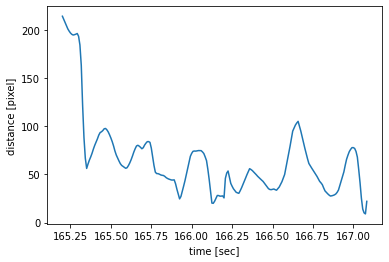

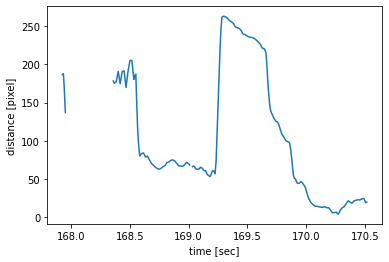

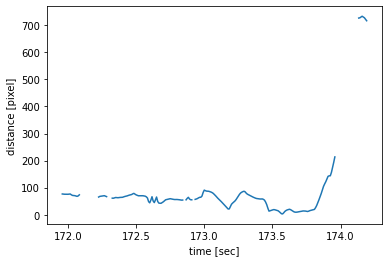

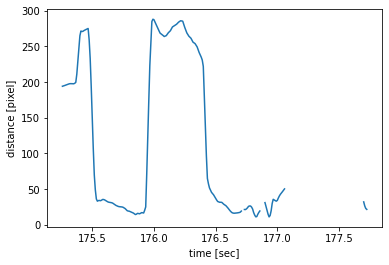

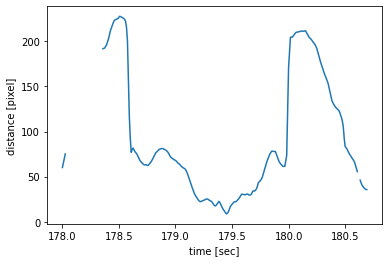

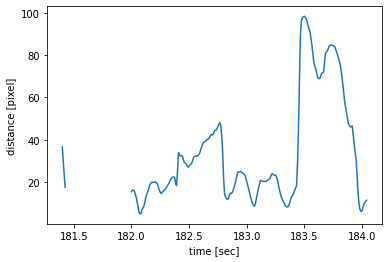

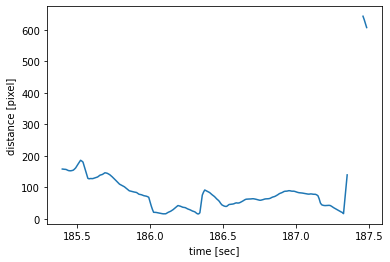

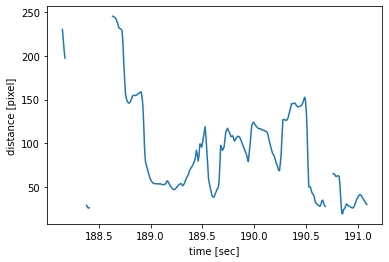

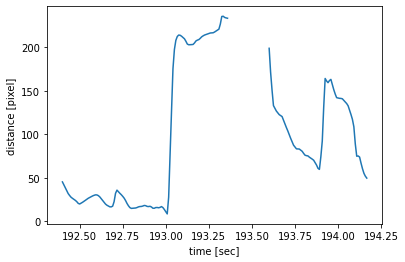

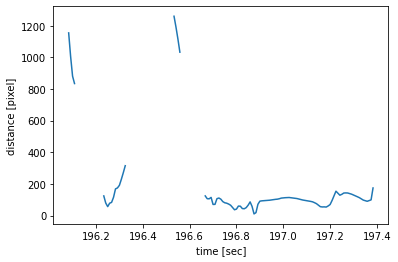

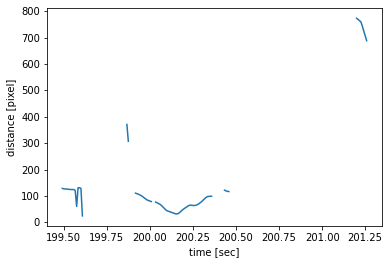

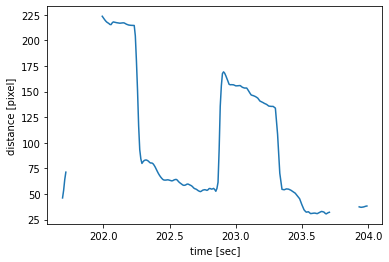

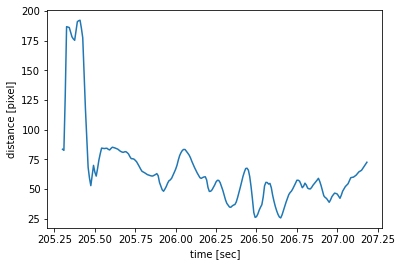

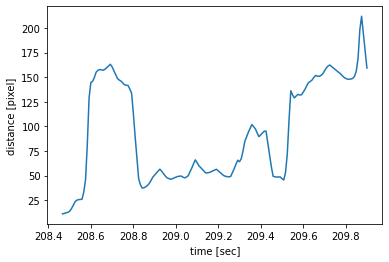

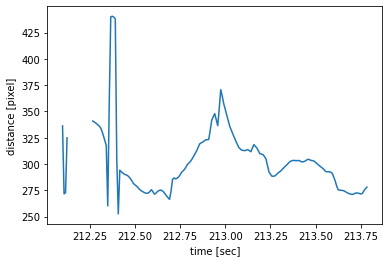

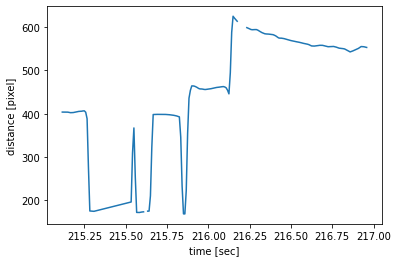

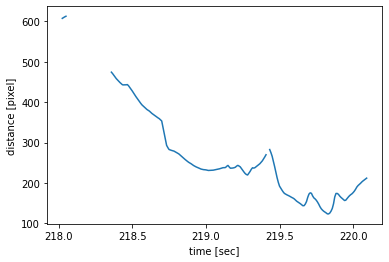

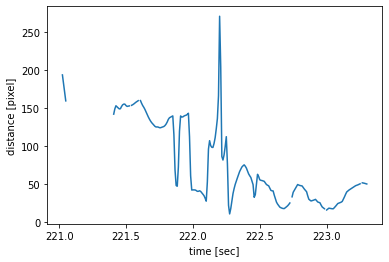

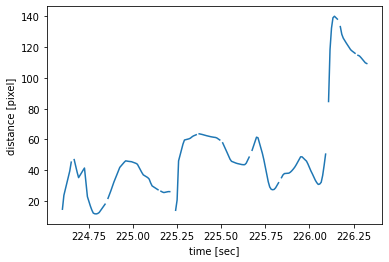

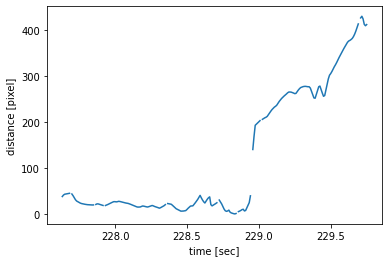

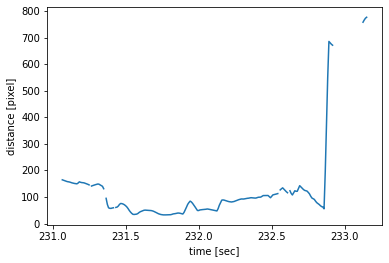

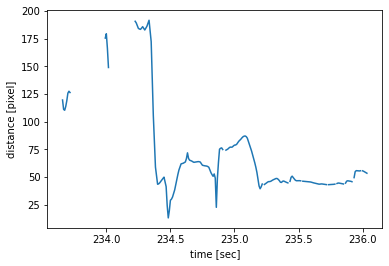

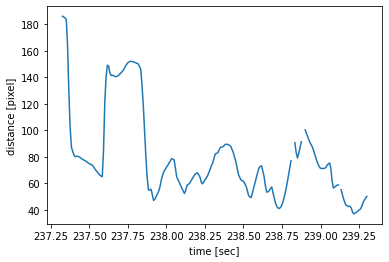

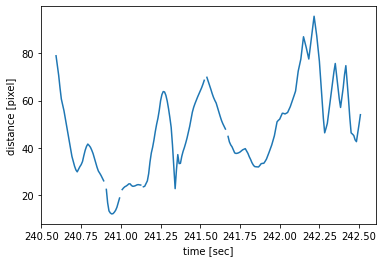

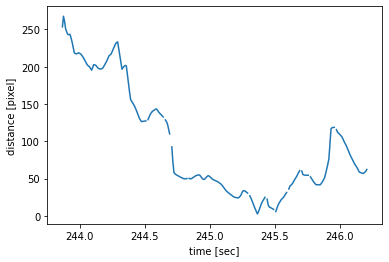

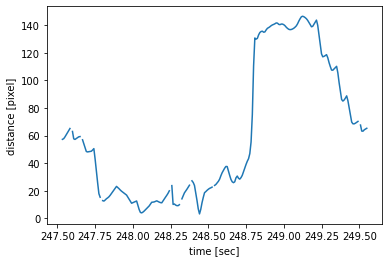

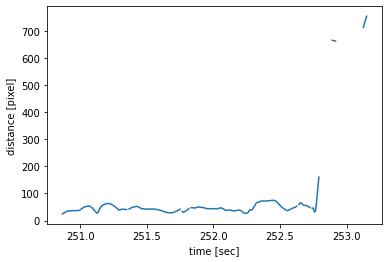

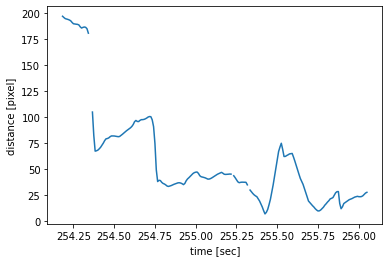

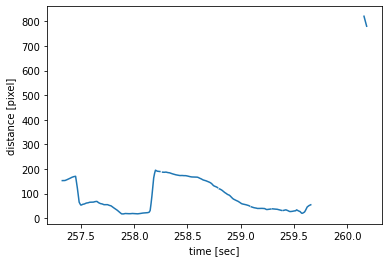

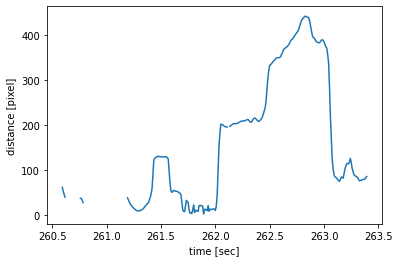

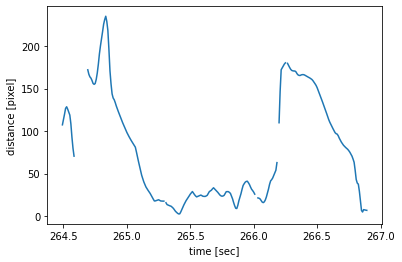

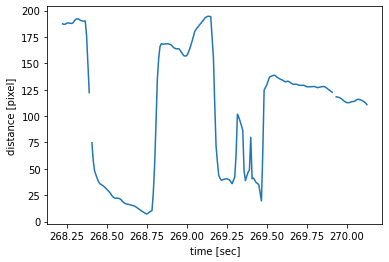

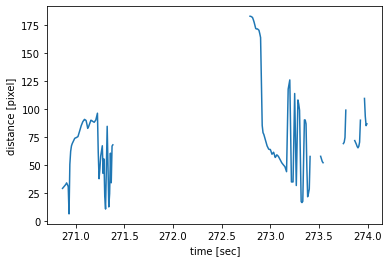

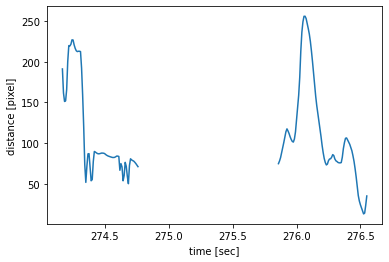

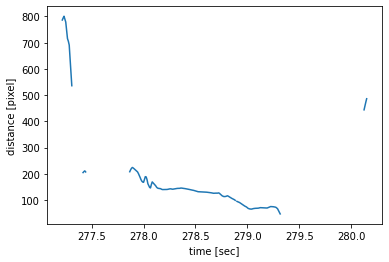

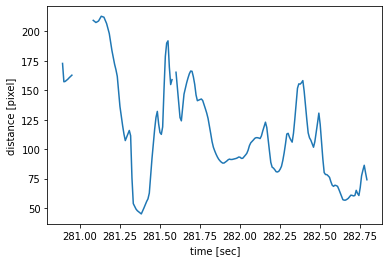

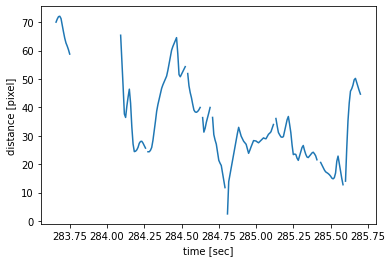

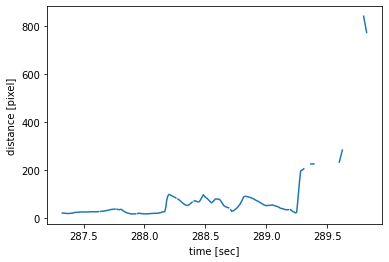

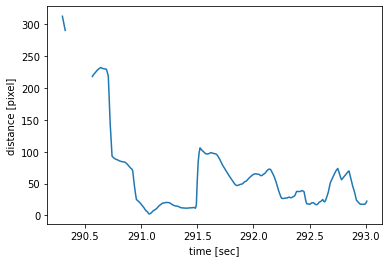

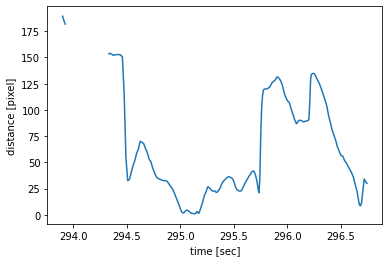

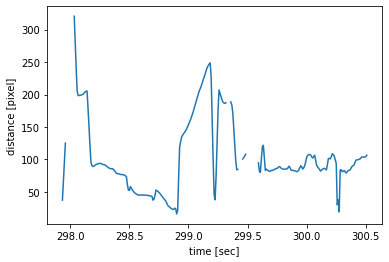

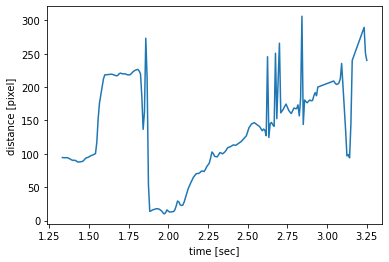

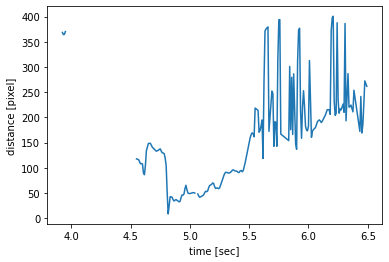

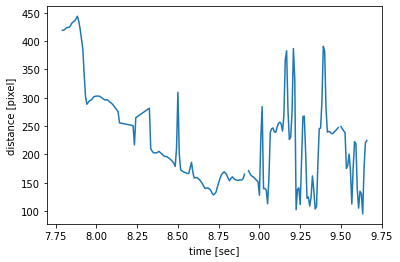

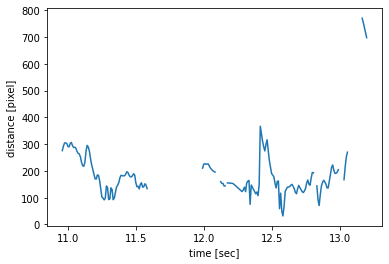

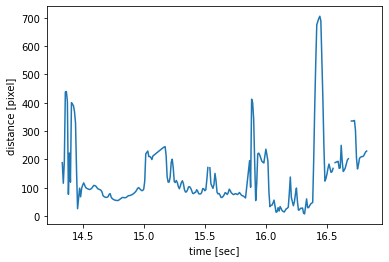

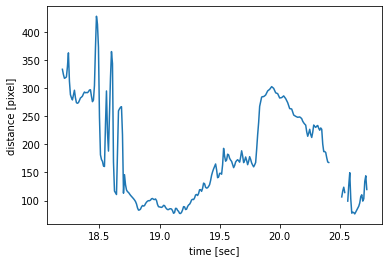

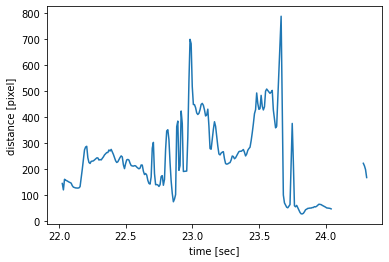

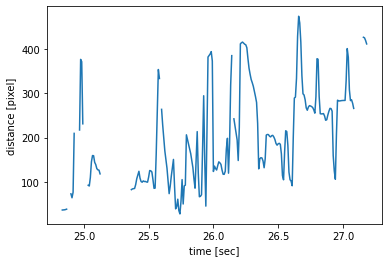

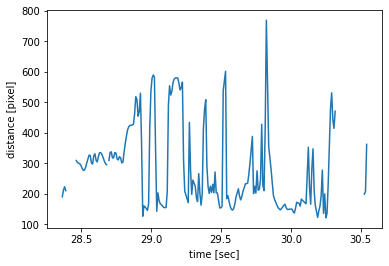

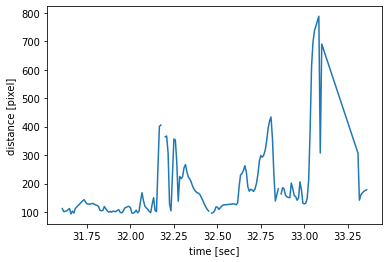

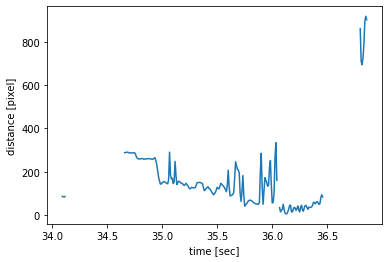

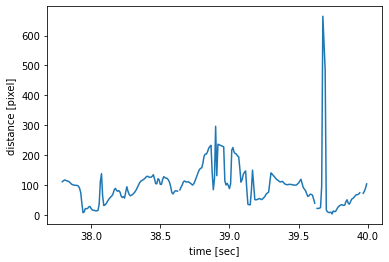

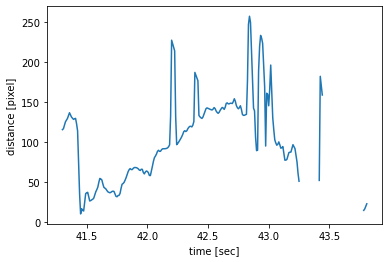

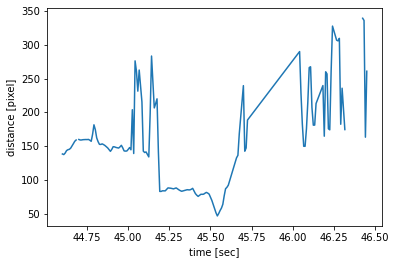

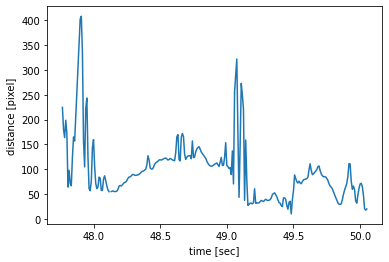

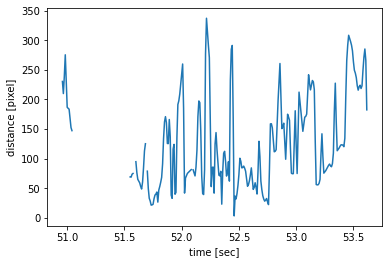

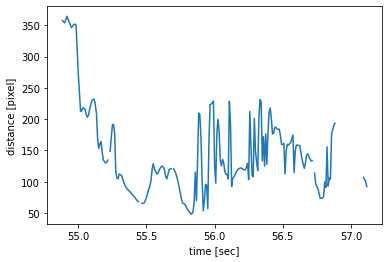

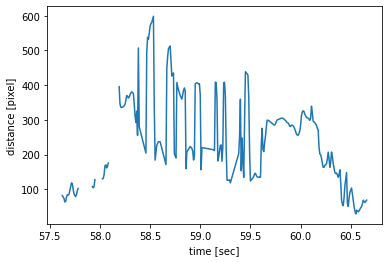

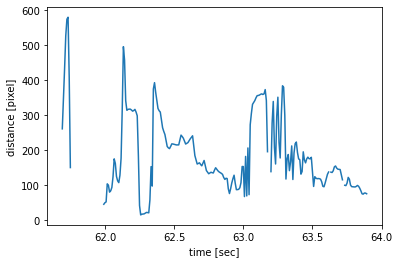

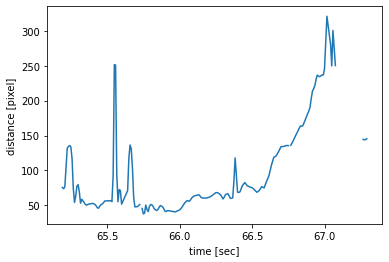

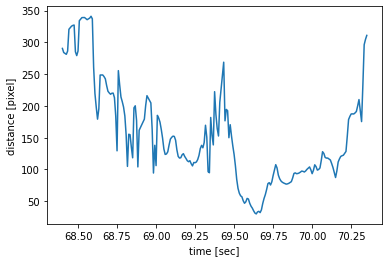

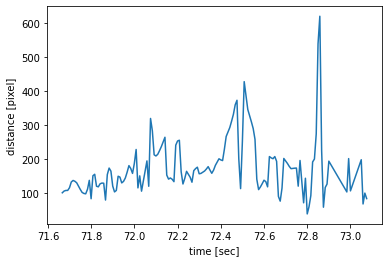

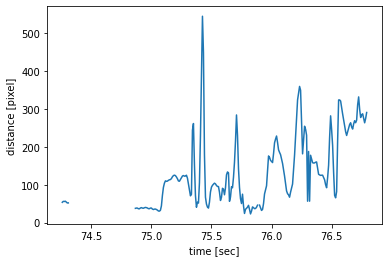

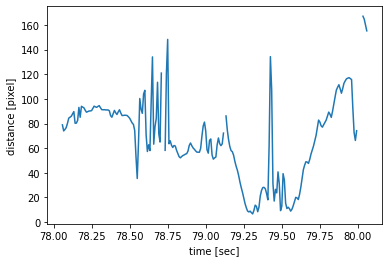

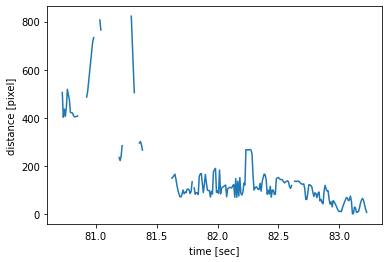

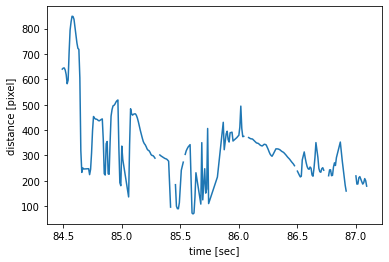

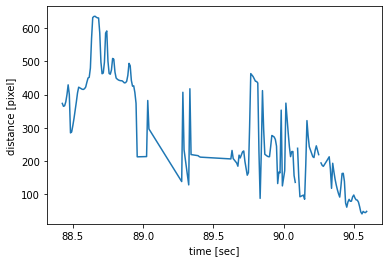

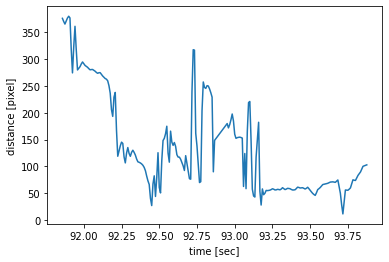

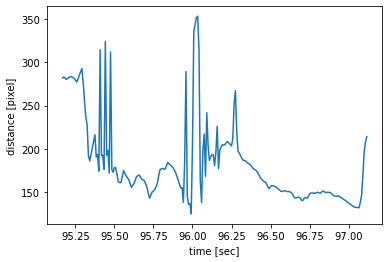

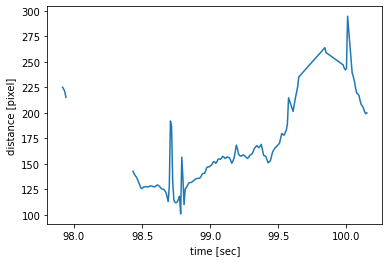

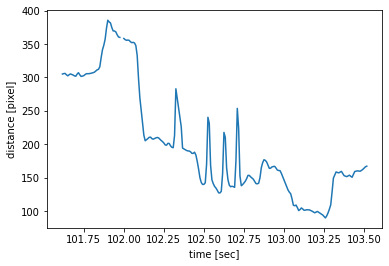

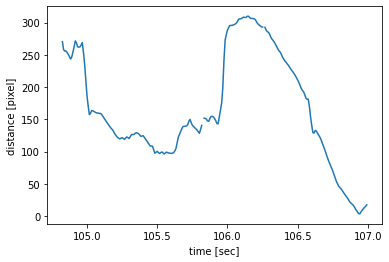

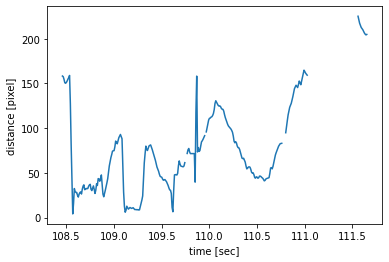

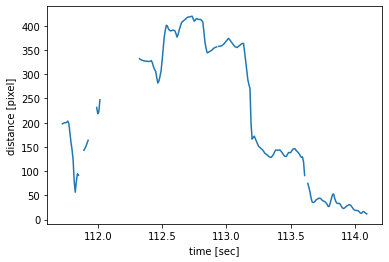

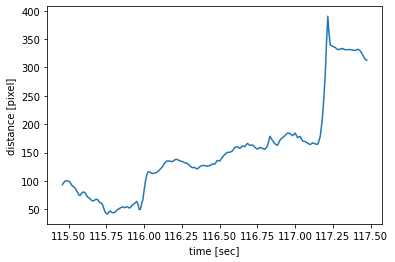

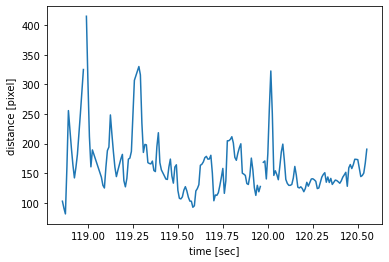

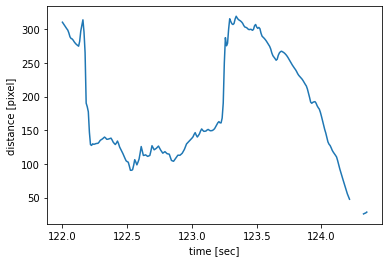

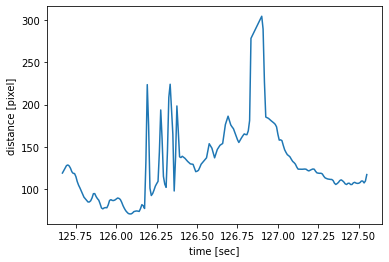

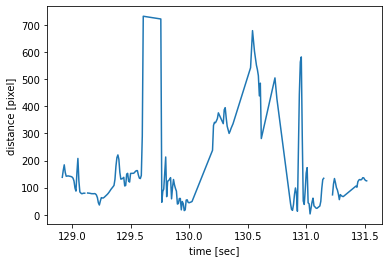

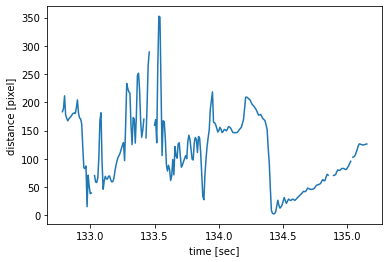

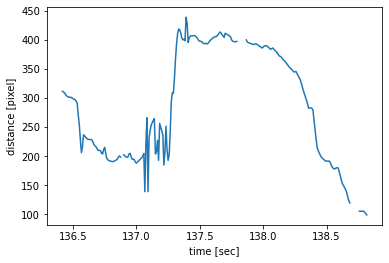

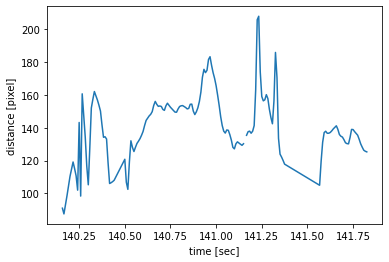

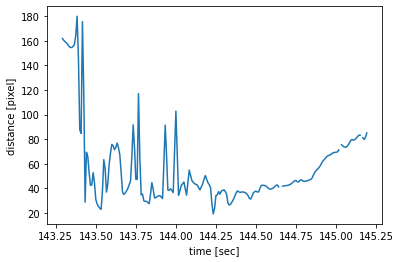

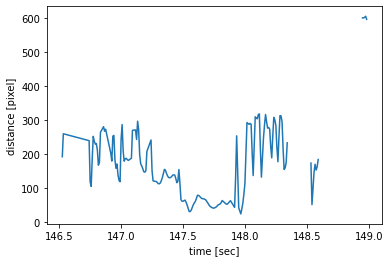

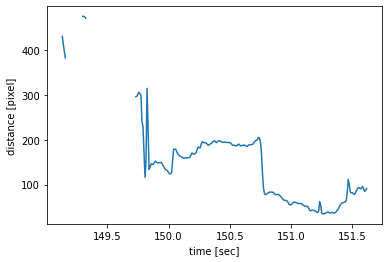

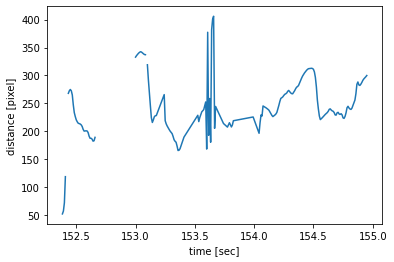

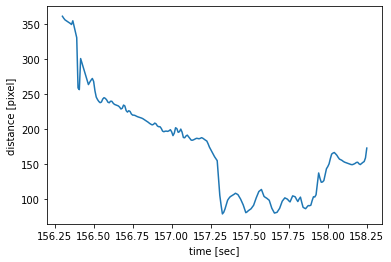

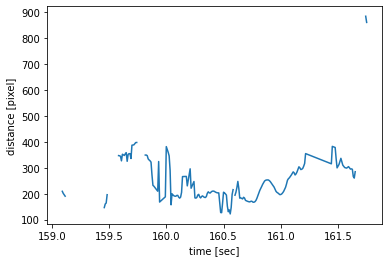

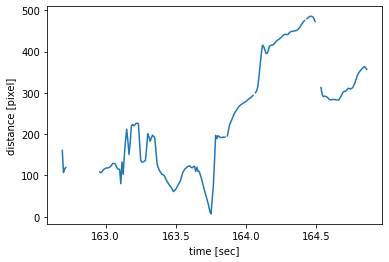

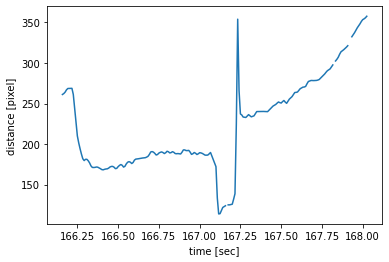

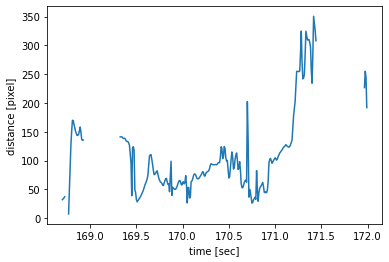

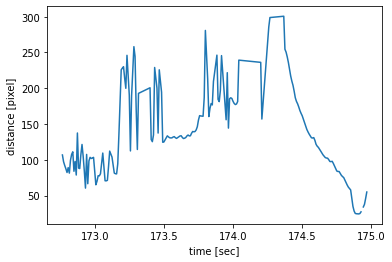

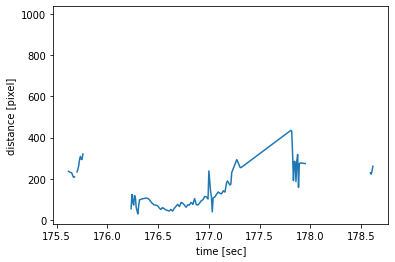

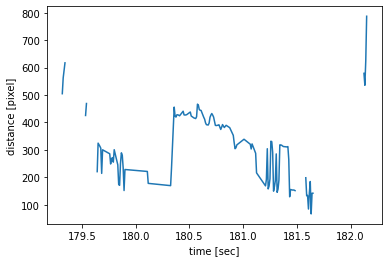

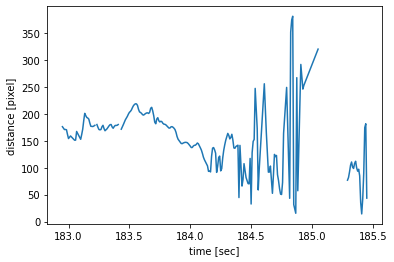

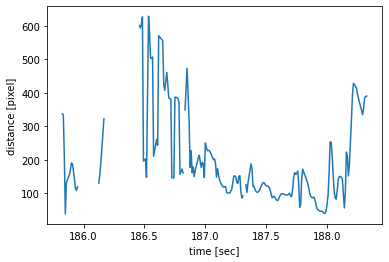

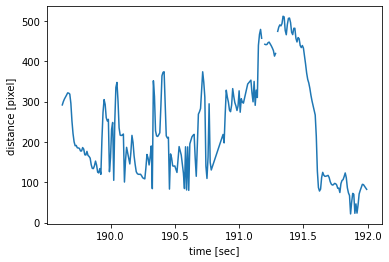

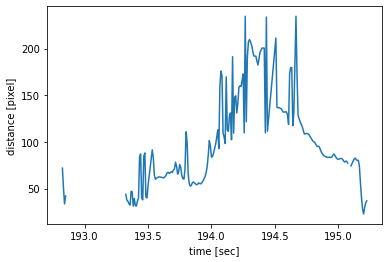

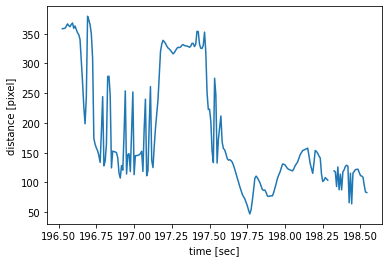

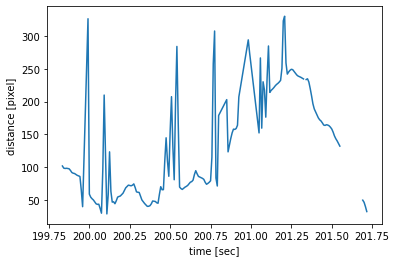

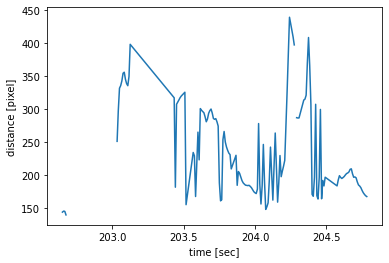

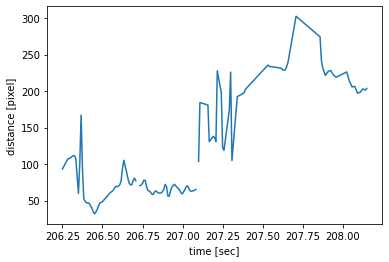

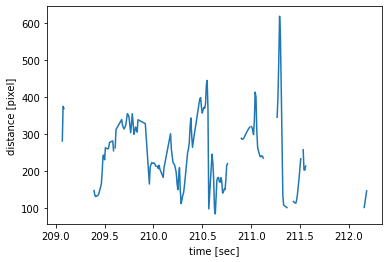

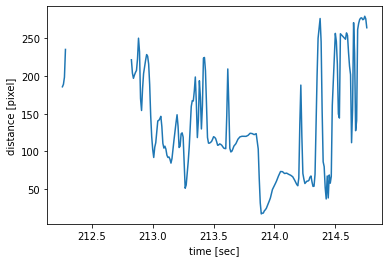

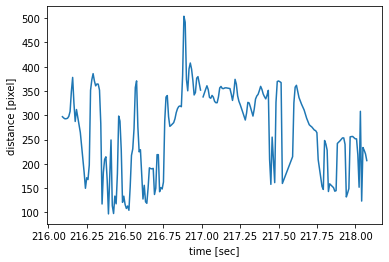

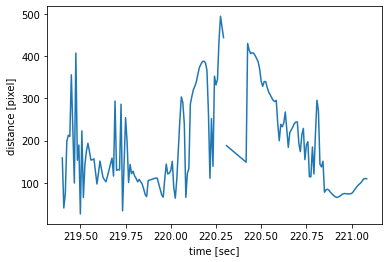

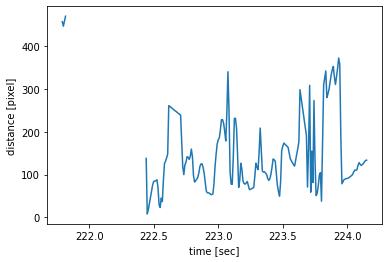

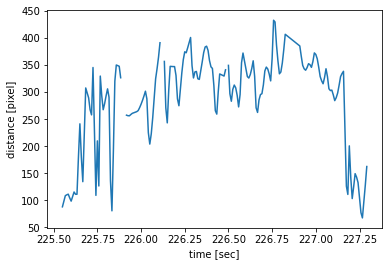

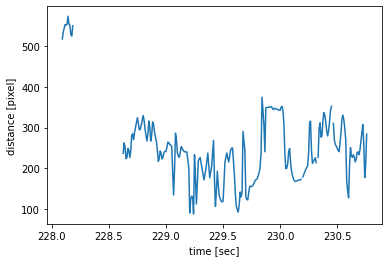

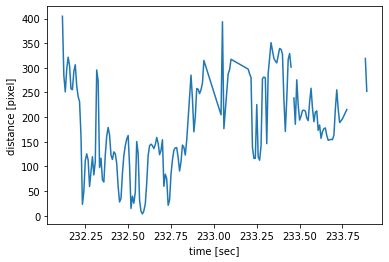

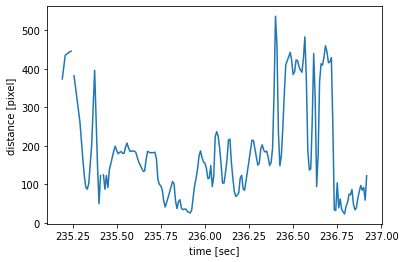

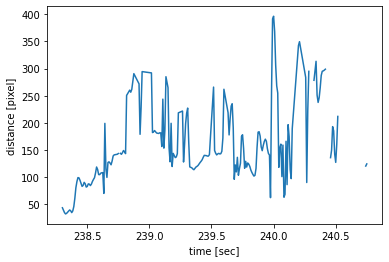

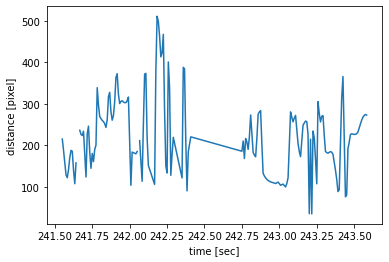

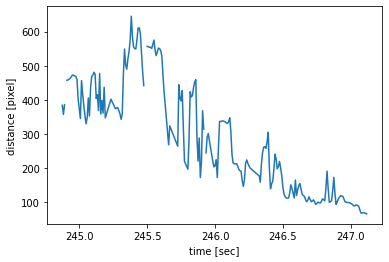

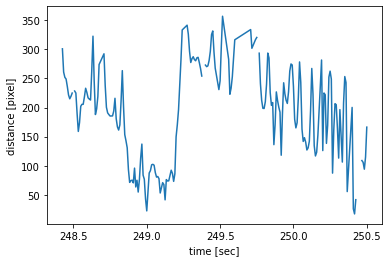

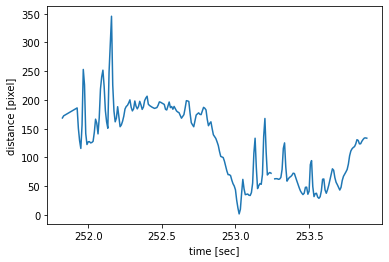

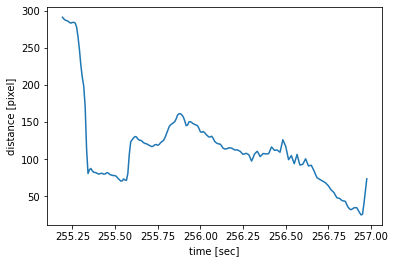

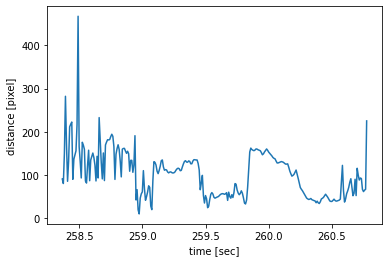

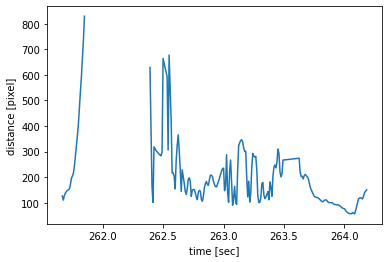

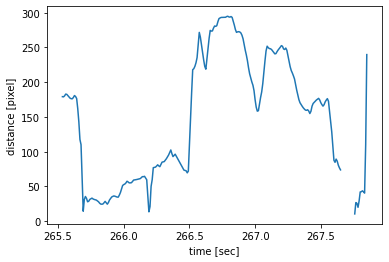

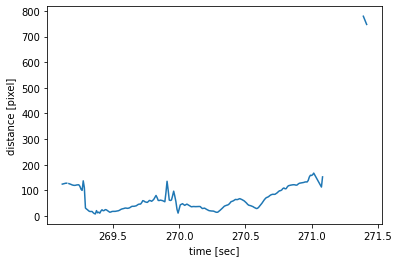

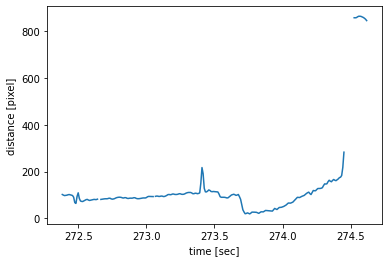

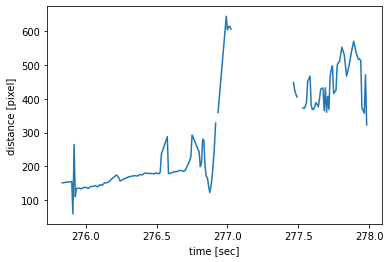

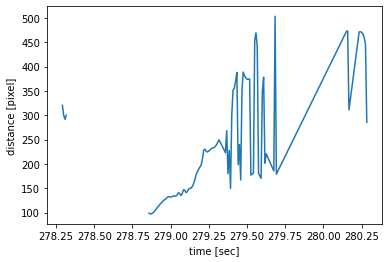

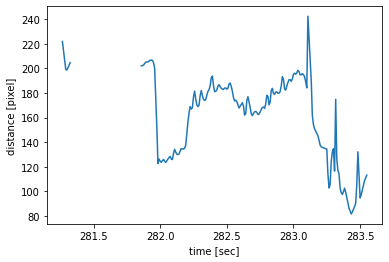

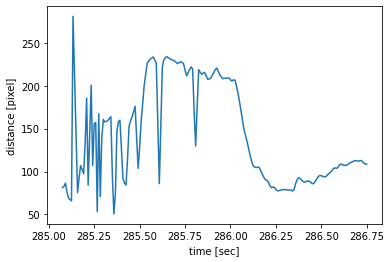

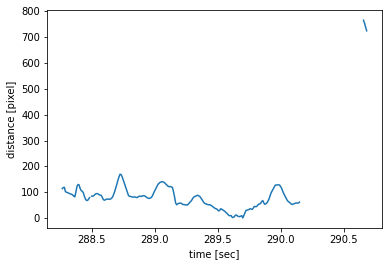

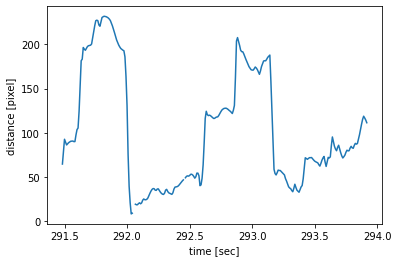

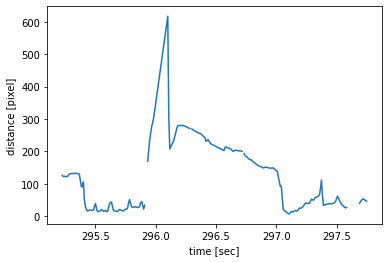

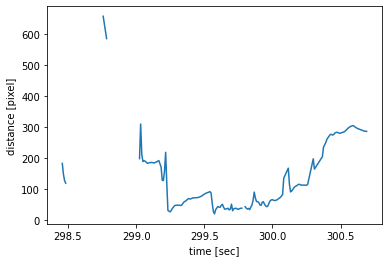

In [14]:
import matplotlib.pyplot as plt

# gaze stats per trial
gaze_info = {}

for p in [p_a, p_b]:

    pname = f'{p.experiment}_{p.name}'
    # gaze_info[f'{p.experiment}_{p.name}'] = {}

    for task in p.tasks.values():

        if task.name != "int":
            continue
        
        # skip tasks without merged data
        if not hasattr(task, 'merged'):
            print(f'ERROR: {task.name} does not have merged data')
            continue

        # calc trial number
        task.trial_number()

        for trial, g in task.merged.groupby('trial_number'):
            trial = str(int(trial))

            # check each gaze point (in scene, in range)
            g = g.assign(
                in_range=(g["Point of Regard Binocular X [px]"].between(-218, 1178)
                          & g["Point of Regard Binocular Y [px]"].between(-130, 850)),
                in_scene=(g["Point of Regard Binocular X [px]"].between(0, 960)
                          & g["Point of Regard Binocular Y [px]"].between(0, 720))
            )

            g = g[g['in_range']]

            user = g[['user.u', 'user.v']]
            user.columns = ['u', 'v']
            target = g[['target.u', 'target.v']]
            target.columns = ['u', 'v']
            gaze = g[["Point of Regard Binocular X [px]", "Point of Regard Binocular Y [px]"]]
            gaze.columns = ['u', 'v']

            gaze.loc[~g['in_range'], ["Point of Regard Binocular X [px]", "Point of Regard Binocular Y [px]"]] = np.NaN

            dist_from_target = np.sqrt((gaze.u - target.u)**2 + (gaze.v - target.v)**2)
            dist_from_user = np.sqrt((gaze.u - user.u)**2 + (gaze.v - user.v)**2)

            fig = plt.figure()
            plt.plot(dist_from_target)
            plt.xlabel('time [sec]')
            plt.ylabel('distance [pixel]')



In [15]:
# marker analysis

head_rot = {}
hip_rot = {}
fb_rot = {}
lr_rot = {}
distance_traveled = {} 

for p in [p_a, p_b]:
    head_rot[f'{p.experiment}_{p.name}'] = {}
    hip_rot[f'{p.experiment}_{p.name}'] = {}
    fb_rot[f'{p.experiment}_{p.name}'] = {}
    lr_rot[f'{p.experiment}_{p.name}'] ={}

    distance_traveled[f'{p.experiment}_{p.name}'] = {}

    for task in p.tasks.values():
        
        # if task.rd_path is not None:
        #     try:
        #         task.align()
        #     except Exception as e:
        #         print(f"ERROR: {task.name} failed alignment {e}")
        #         continue

        if not hasattr(task, 'merged'):
            print(f'ERROR: {task.name} does not have merged data')
            continue

        # calc trial number
        task.trial_number()

        head_rot[f'{p.experiment}_{p.name}'][task.name] = {}
        hip_rot[f'{p.experiment}_{p.name}'][task.name] = {}
        fb_rot[f'{p.experiment}_{p.name}'][task.name] = {}
        lr_rot[f'{p.experiment}_{p.name}'][task.name] = {}

        distance_traveled[f'{p.experiment}_{p.name}'][task.name] = {}

        # for each trial
        for k, g in task.merged.groupby('trial_number'):
            # do the following
            # print(k)
            # print(g)

            trial = str(int(k))

            # head rotations total distance with respect to catersain axes 
            # of centeroid of ETG glasses
            angle_per_step = calc_head_rotations(g)
            head_rot[f'{p.experiment}_{p.name}'][task.name][trial] = angle_per_step.sum(axis=0)

            # hip rotation with respect to y-axis
            hip_rot_per_step = hip_rotation(g)
            hip_rot[f'{p.experiment}_{p.name}'][task.name][trial] = hip_rot_per_step.sum(axis=0)['lasis']

            # total trunk distance 
            # forward backwards angle midpoint between sholders
            # project onto the zy plane
            # angle in zy plane
            shoulder_midpoint = pd.DataFrame(
                (g[['lsho.x', 'lsho.y', 'lsho.z']].to_numpy() + g[['rsho.x', 'rsho.y', 'rsho.z']].to_numpy()) / 2,
                columns=['x', 'y', 'z']
            )

            frwd_back_angle = np.arctan2(shoulder_midpoint['y'], shoulder_midpoint['z'])

            frwd_back_step_diff = angle_diff(frwd_back_angle)
            total_frwd_back = np.sum(frwd_back_step_diff, axis=0)
            fb_rot[f'{p.experiment}_{p.name}'][task.name][trial] = total_frwd_back

            # left-right
            left_right_angle = np.arctan2(shoulder_midpoint['y'], shoulder_midpoint['x'])

            left_right_step_diff = angle_diff(left_right_angle)
            total_left_right = np.sum(left_right_step_diff, axis=0)
            lr_rot[f'{p.experiment}_{p.name}'][task.name][trial] = total_left_right

            # total distance traveled, each marker
            distance_traveled[f'{p.experiment}_{p.name}'][task.name][trial] = total_marker_distance(task)


    print(f'{p.name:^40}')
    print("head_rot total twist around each axis")
    # print(head_rot[f'{p.experiment}_{p.name}'])
    # phead_rot = pd.DataFrame(head_rot[f'{p.experiment}_{p.name}'])
    # for t in head_rot[f'{p.experiment}_{p.name}'].values():
    #     print(t, type(t))
    #     break


    phead_rot = pd.concat([pd.DataFrame(t) for t in head_rot[f'{p.experiment}_{p.name}'].values()], keys=head_rot[f'{p.experiment}_{p.name}'].keys(), axis=0)
    # phead_rot = pd.DataFrame(phead_rot[f'{p.experiment}_{p.name}'])
    phead_rot = np.degrees(phead_rot)
    # print(phead_rot.T)
    # phead_rot.describe().to_csv('out.csv', mode='a')
    print(phead_rot.T.describe())
    print()

    print("hip_rot total twist around y")
    # print(head_rot[f'{p.experiment}_{p.name}'])
    phip_rot = pd.DataFrame(hip_rot[f'{p.experiment}_{p.name}'])
    phip_rot = np.degrees(phip_rot) 
    phip_rot.describe().to_csv('out.csv', mode='a')

    print(phip_rot.describe())
    print()

    print("forward-backwards trunk rotation")
    ptrunk_forw_back = pd.DataFrame(fb_rot[f'{p.experiment}_{p.name}'])
    ptrunk_forw_back = np.degrees(ptrunk_forw_back)
    ptrunk_forw_back.describe().to_csv('out.csv', mode='a')

    print(ptrunk_forw_back.describe())
    print()


    print("left-right trunk rotation")
    ptrunk_lr = pd.DataFrame(lr_rot[f'{p.experiment}_{p.name}'])
    ptrunk_lr = np.degrees(ptrunk_lr)
    ptrunk_lr.describe().to_csv('out.csv', mode='a')
    print(ptrunk_lr.describe())
    print()

    print('distance traveled')
    pdist_travel = pd.concat([pd.DataFrame(t) for t in distance_traveled[f'{p.experiment}_{p.name}'].values()], keys=distance_traveled[f'{p.experiment}_{p.name}'].keys(), axis=0).T
    # pdist_travel = pd.DataFrame(distance_traveled[f'{p.experiment}_{p.name}'])
    # pdist_travel.describe().to_csv('tot_dist.csv')
    print(pdist_travel.describe())
    print()


ERROR: ducks does not have merged data
ERROR: ducks does not have merged data
ERROR: qs_closed does not have merged data
ERROR: qs_cross does not have merged data
ERROR: qs_open does not have merged data
                  047                   
head_rot total twist around each axis
               ap                               avoid                          \
                x           y           z           x            y          z   
count   90.000000   90.000000   90.000000   90.000000    90.000000  90.000000   
mean     6.689941  125.706917    4.515514   21.211571   195.673166   8.710612   
std     17.477307  112.844567   11.495106   20.478746   155.991361  14.223846   
min      1.330139   24.724775    1.438705    1.414675     9.936164   1.424740   
25%      3.270354   52.740295    2.492318   10.640089    80.022065   3.988163   
50%      4.464925   82.139618    3.014717   18.005326   167.604799   5.135492   
75%      5.419603  143.347829    3.603529   24.876398   263.241405   